In [505]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KernelDensity
from scipy import integrate
import warnings
warnings.filterwarnings('ignore')

In [506]:
df_wind = pd.read_excel("版本1_缺失值处理_铅钡风化修改版.xlsx")
df_nowind = pd.read_excel("版本1_缺失值处理_铅钡未风化修改版.xlsx")
df_nowind

,Q2-二氧化硅(SiO2),Q5-氧化钙(CaO),Q10-氧化铅(PbO),Q12-五氧化二磷(P2O5)
0,37.36,0.00,9.30,5.75
1,31.94,0.47,29.14,0.14
2,34.34,4.49,39.22,0.00
3,36.93,4.24,37.74,1.41
4,65.91,1.60,16.55,1.62
5,69.71,0.46,19.76,0.17
6,75.51,0.64,16.16,0.13
7,65.91,0.38,22.05,0.42
8,60.12,0.89,17.24,1.46
9,61.28,0.84,15.99,0.00


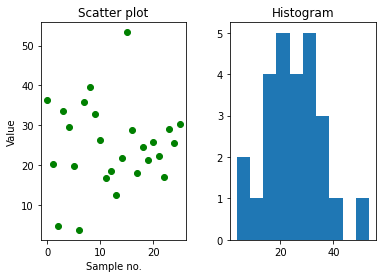

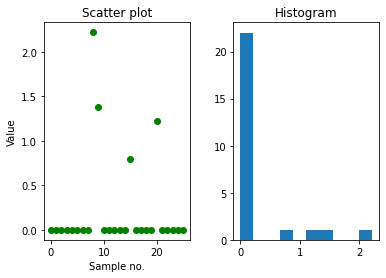

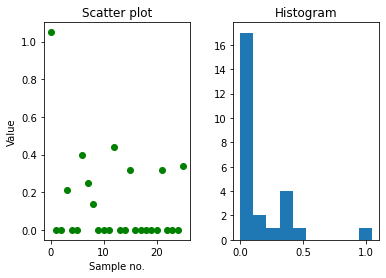

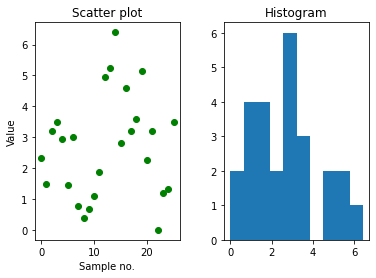

In [507]:
for i in range(0,4):
    x_train = np.array(df.iloc[:,i])
    fig, ax = plt.subplots(nrows=1, ncols=2)
    plt.subplot(121)
    plt.scatter(np.arange(len(x_train)), x_train, c='green')
    plt.xlabel('Sample no.')
    plt.ylabel('Value')
    plt.title('Scatter plot')
    plt.subplot(122)
    plt.hist(x_train)
    plt.title('Histogram')
    fig.subplots_adjust(wspace=.3)
    plt.show()

In [508]:
max_al = max(df_nowind.iloc[:,0])
max_al

75.51

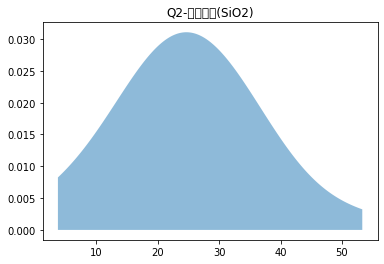

optimal bandwidth: 8.72


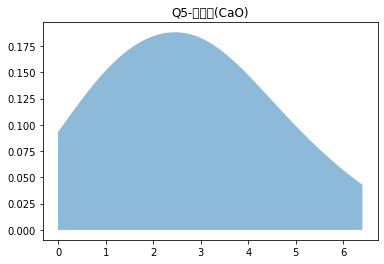

optimal bandwidth: 1.24


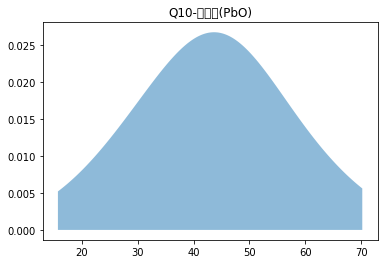

optimal bandwidth: 9.49


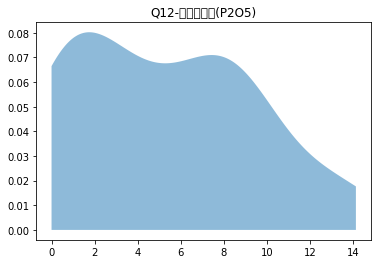

optimal bandwidth: 1.98


IndexError: single positional indexer is out-of-bounds

In [518]:
for i in range(0,6):
    x_train = np.array(df_wind.iloc[:,i])
    x_train = x_train[:,None]
    max_al = max(df_wind.iloc[:,i])
    min_al = min(df_wind.iloc[:,i])
    
    x_test = np.linspace(min_al, max_al, 1000)
    bandwidth = np.arange(1, 10, 0.01)
    kde = KernelDensity(kernel='gaussian')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(x_train)

    kde = grid.best_estimator_
    log_dens = kde.score_samples(x_test[:,None])
    plt.fill_between(x_test,np.exp(log_dens),alpha=0.5)
    plt.title(df_wind.columns[i])
#     name = "./图/"+"铅钡未风化"+df_wind.columns[i]+".jpg"
#     plt.savefig(name)
    plt.show()
    print("optimal bandwidth: " + "{:.2f}".format(kde.bandwidth))

In [509]:
from functools import partial
bandwidth = np.arange(1, 10, 0.1)
grid_ba = GridSearchCV(KernelDensity(kernel='gaussian'),{'bandwidth': bandwidth},cv=LeaveOneOut())

def sf(grid, x):
    return np.exp(grid.score_samples([[x]])[0])
def kde_func(df):
    df_kde = pd.DataFrame()
    for column in df.columns[0:df.shape[1]]:
        cdf = []
        grid_ba.fit(df[column].to_numpy()[:,None])
        for x in df[column]:
            p = integrate.quad(partial(sf, grid_ba),-np.inf,x)[0] if x!=0 else 0
            cdf.append(p)
        df_kde[column] = cdf
    return df_kde
cdf_nowind = kde_func(df_nowind)
cdf_wind = kde_func(df_wind)

In [512]:
def findx(percent, grid, delta= 1e-10):
    def sf(x):
        return np.exp(grid.score_samples([[x]])[0])
    
    if (percent < 0 or percent >= 1):
        raise ValueError("percent should be (0,1)")
        
    low = -100
    step = 10
    max_round = 1000
    r = 0
    left_high = -100
    right_high = 100
    high = right_high
    val = integrate.quad(sf, low, high)[0]
    
    while (abs(percent -val) > delta):
        if (val > percent):
            right_high = high
        else:
            left_high = high
        high = float(left_high + right_high) /2
        val = integrate.quad(sf, low, high)[0]
        
        r += 1
        if (r >= max_round):
            break
    return high

global grid_ba
def grid_ba_fit(num):
    global grid_ba
    grid_ba = GridSearchCV(KernelDensity(kernel='gaussian'),{'bandwidth': bandwidth},cv=LeaveOneOut())
    grid_ba.fit(df_nowind.iloc[:,num].to_numpy()[:,None])

num = 0
count = 0
df_arr = pd.DataFrame(columns=['%',df_wind.columns[num]])
for i in cdf_wind.iloc[:,num]:
    grid_ba_fit(num)
    global grid_ba
    count += 1;
    df_arr.loc[count] = [i,findx(i,grid_ba)]
    print(i,findx(i,grid_ba))

0.8165949237758698 66.3807540491689
0.35683156355394097 50.91738389455713
0.06188574670953355 33.17996261175722
0.7572947612950879 64.23078809748404
0.6514284585251542 60.64136030036025
0.3465236640963902 50.5632585438434
0.054417594655375615 32.55862427176908
0.8064317144875378 65.99576892331243
0.8736148124393153 68.7765188049525
0.741059055722495 63.67041815537959
0.5478656782653369 57.15550764580257
0.26193998583201644 47.23990297643468
0.3085519086977864 49.18767899507657
0.16658785170553894 41.14326514536515
0.4040847924675685 52.480999066028744
0.9764654844959915 76.71120010782033
0.6262799493976796 59.79341098573059
0.29536310868907556 48.67347863037139
0.4958006556850685 55.43899380136281
0.39331833408265565 52.13086000876501
0.5317326057278027 56.619365501683205
0.4220969443035076 53.06246941909194
0.27222734171167 47.705081972526386
0.6370138220792799 60.155511199263856
0.5215752659566683 56.28371946513653
0.6730139758573785 61.36805693968199


In [513]:
cdf_wind.iloc[:,0]

0     0.816595
1     0.356832
2     0.061886
3     0.757295
4     0.651428
5     0.346524
6     0.054418
7     0.806432
8     0.873615
9     0.741059
10    0.547866
11    0.261940
12    0.308552
13    0.166588
14    0.404085
15    0.976465
16    0.626280
17    0.295363
18    0.495801
19    0.393318
20    0.531733
21    0.422097
22    0.272227
23    0.637014
24    0.521575
25    0.673014
Name: Q2-二氧化硅(SiO2), dtype: float64

In [514]:
cdf_nowind.iloc[:,0]

0     0.117968
1     0.047424
2     0.076781
3     0.112118
4     0.804136
5     0.892486
6     0.968030
7     0.804136
8     0.635961
9     0.670397
10    0.488762
11    0.375360
12    0.303927
13    0.444741
14    0.347873
15    0.858256
16    0.730220
17    0.366970
18    0.369059
19    0.654357
20    0.470227
21    0.220055
22    0.740755
Name: Q2-二氧化硅(SiO2), dtype: float64

In [404]:
# arr = pd.Series(arr)
# arr.column=df_wind.columns[0]
df_arr.to_excel("预测高钾_风化前的数据.xlsx") 